In [153]:
import numpy as np
import torch
import torch.nn as nn
import random

from model import TrajectoryModel
from matplotlib import pyplot as plt

import gymnasium as gym
import argparse
import time


In [154]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



device(type='cpu')

## Loading the trajectories from data

In [155]:
traj_states = torch.load("data/pendulum_states.pt")
traj_actions = torch.load("data/pendulum_actions.pt")
traj_states.to(device)
traj_actions.to(device)
print("traj_states size", traj_states.size())
print("traj_actions size", traj_actions.size())
state_dim = traj_states.size()[2]
print("state_dim", state_dim)
act_dim = 1
n_traj = traj_states.size()[0]
traj_len = traj_states.size()[1]
print("n_traj =", n_traj)
print("traj_len =", traj_len)



traj_states size torch.Size([500000, 100, 3])
traj_actions size torch.Size([500000, 100])
state_dim 3
n_traj = 500000
traj_len = 100


## Normalizing the data

In [156]:
# print(torch.mean(traj_states, dim = 0).repeat(n_traj, 1, 1).size())
# print(torch.mean(traj_actions, dim = 0).repeat(n_traj, 1, 1).size())
#traj_states = (traj_states - torch.mean(traj_states, dim = 1).repeat(n_traj, 1, 1)) / torch.std(traj_states, dim = 1).repeat(n_traj,1,1)
traj_states = (traj_states - torch.mean(traj_states, dim=(0,1), keepdim=True)) / torch.std(traj_states, dim=(0,1), keepdim=True)
#traj_actions = (traj_actions - torch.mean(traj_act, dim=0).repeat(n_traj, 1)) / torch.std(traj_actions, dim=0)#.repeat(n_traj, 1)
# #yyyy = traj_actions - torch.mean(traj_actions, dim = 0).repeat(n_traj, 1, 1)

In [157]:
# print(traj_states.shape)
# mean = torch.mean(traj_states, dim=0, keepdim=True)  # shape: [n_traj, 1, dim]
# std = torch.std(traj_states, dim=0, keepdim=True)    # shape: [n_traj, 1, dim]
# traj_states = (traj_states - mean) / std

# print(traj_actions.shape)
# mean = torch.mean(traj_actions, dim=0, keepdim=True)  # shape: [n_traj, 1]
# std = torch.std(traj_actions, dim=0, keepdim=True)    # shape: [n_traj, 1]
# traj_actions = (traj_actions - mean) / std

## Splitting the data into Training and Testing set

In [158]:
train_traj_states = traj_states[0:int(0.95*n_traj),:,:]
train_traj_actions = traj_actions[0:int(0.95*n_traj),:]

n_train_traj = train_traj_states.size()[0]

test_traj_states = traj_states[int(0.95*n_traj):,:,:]
test_traj_actions = traj_actions[int(0.95*n_traj):,:]

n_test_traj = test_traj_states.size()[0]

## Function to obtain batch of trajectories

In [159]:
def get_batch(batch_size, n_traj, traj_states, traj_actions):
    idxs = random.choices(range(n_traj), k=batch_size)
    batch_states = traj_states[idxs,:,:]
    batch_actions = traj_actions[idxs,:]
    
    return batch_states, batch_actions.unsqueeze(-1)

## Decision Transformer Code

In [160]:
class RnnDynaMo(TrajectoryModel):

    """
    This model uses RNN to model (state_1, action_1, state_2, action_2, ...)
    """

    def __init__(
            self,
            state_dim,
            act_dim,
            hidden_size,
            max_length=None,
            max_ep_len=100,
            action_tanh=True,
            **kwargs
    ):
        super().__init__(state_dim, act_dim, max_length=max_length)

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)  # LSTM instead of transformer

        self.embed_timestep = nn.Embedding(max_ep_len, hidden_size)
        self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
        self.embed_action = torch.nn.Linear(self.act_dim, hidden_size)

        self.embed_ln = nn.LayerNorm(hidden_size)

        self.predict_state = torch.nn.Linear(hidden_size, self.state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(hidden_size, self.act_dim)] + ([nn.Tanh()] if action_tanh else []))
        )
        self.predict_return = torch.nn.Linear(hidden_size, 1)
        
        
        
        
        
        
    def get_state(self, states, actions, timesteps, **kwargs):

        states = states.reshape(1, -1, self.state_dim)
        actions = actions.reshape(1, -1, self.act_dim)
        timesteps = timesteps.reshape(1, -1)

        if self.max_length is not None:
            states = states[:,-self.max_length:]
            actions = actions[:,-self.max_length:]
            timesteps = timesteps[:,-self.max_length:]

            states = torch.cat(
                [torch.zeros((states.shape[0], self.max_length-states.shape[1], self.state_dim), device=states.device), states],
                dim=1).to(dtype=torch.float32)
            actions = torch.cat(
                [torch.zeros((actions.shape[0], self.max_length - actions.shape[1], self.act_dim),
                             device=actions.device), actions],
                dim=1).to(dtype=torch.float32)
            timesteps = torch.cat(
                [torch.zeros((timesteps.shape[0], self.max_length-timesteps.shape[1]), device=timesteps.device), timesteps],
                dim=1
            ).to(dtype=torch.long)
        else:
            attention_mask = None

        state_preds, action_preds = self.forward(
            states, actions, timesteps, **kwargs)

        return state_preds[0,-1]

        
        

    def forward(self, states, actions, timesteps):

        states = states.to(device)
        actions = actions.to(device)

        batch_size, seq_length = states.shape[0], states.shape[1]

        # embed each modality with a different head
        state_embeddings = self.embed_state(states)
        action_embeddings = self.embed_action(actions)
        time_embeddings = self.embed_timestep(timesteps)

        # time embeddings are treated similar to positional embeddings
        state_embeddings = state_embeddings + time_embeddings
        action_embeddings = action_embeddings + time_embeddings

        # which works nice in an autoregressive sense since states predict actions
        stacked_inputs = torch.stack(
            (state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(batch_size, 2*seq_length, self.hidden_size)
        stacked_inputs = self.embed_ln(stacked_inputs)

        # we feed in the input embeddings (not word indices as in NLP) to the model
        lstm_outputs, _ = self.lstm(stacked_inputs)  # LSTM instead of transformer
        x = lstm_outputs

        # reshape x so that the second dimension corresponds to the original
        # returns (0), states (1), or actions (2); i.e. x[:,1,t] is the token for s_t
        x = x.reshape(batch_size, seq_length, 2, self.hidden_size).permute(0, 2, 1, 3)

        # get predictions
        state_preds = self.predict_state(x[:,1])    # predict next state given state and action
        action_preds = self.predict_action(x[:,0])  # predict next action given state

        return state_preds, action_preds


In [161]:
model = RnnDynaMo(
            state_dim=state_dim,
            act_dim=act_dim,
            max_length=20,
            max_ep_len=100,
            hidden_size=128
        )


## Training

In [162]:
model.to(device)
batch_size = 256
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.1,
    weight_decay=1e-4,
)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda steps: min((steps+1)/10000, 1)
)

n_epochs = 1500

loss_horizon = 10

train_losses = torch.zeros(n_epochs)

for n in range(n_epochs):
    print('epoch: ', n)
    state_batch, action_batch = get_batch(batch_size, n_train_traj, train_traj_states, train_traj_actions)

    state_pred, action_preds = model.forward(state_batch, action_batch, (torch.arange(0,traj_len,1).unsqueeze(0)).to(device))

    loss = nn.MSELoss()
    #l = loss(state_pred,state_batch.to(device))
    l = loss(state_pred[:,0:loss_horizon,:],state_batch[:,0:loss_horizon,:].to(device))
    train_losses[n] = l.detach().cpu().item()
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    scheduler.step()

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

epoch:  692
epoch:  693
epoch:  694
epoch:  695
epoch:  696
epoch:  697
epoch:  698
epoch:  699
epoch:  700
epoch:  701
epoch:  702
epoch:  703
epoch:  704
epoch:  705
epoch:  706
epoch:  707
epoch:  708
epoch:  709
epoch:  710
epoch:  711
epoch:  712
epoch:  713
epoch:  714
epoch:  715
epoch:  716
epoch:  717
epoch:  718
epoch:  719
epoch:  720
epoch:  721
epoch:  722
epoch:  723
epoch:  724
epoch:  725
epoch:  726
epoch:  727
epoch:  728
epoch:  729
epoch:  730
epoch:  731
epoch:  732
epoch:  733
epoch:  734
epoch:  735
epoch:  736
epoch:  737
epoch:  738
epoch:  739
epoch:  740
epoch:  741
epoch:  742
epoch:  743
epoch:  744
epoch:  745
epoch:  746
epoch:  747
epoch:  748
epoch:  749
epoch:  750
epoch:  751
epoch:  752
epoch:  753
epoch:  754
epoch:  755
epoch:  756
epoch:  757
epoch:  758
epoch:  759
epoch:  760
epoch:  761
epoch:  762
epoch:  763
epoch:  764
epoch:  765
epoch:  766
epoch:  767
epoch:  768
epoch:  769
epoch:  770
epoch:  771
epoch:  772
epoch:  773
epoch:  774
epoc

epoch:  1346
epoch:  1347
epoch:  1348
epoch:  1349
epoch:  1350
epoch:  1351
epoch:  1352
epoch:  1353
epoch:  1354
epoch:  1355
epoch:  1356
epoch:  1357
epoch:  1358
epoch:  1359
epoch:  1360
epoch:  1361
epoch:  1362
epoch:  1363
epoch:  1364
epoch:  1365
epoch:  1366
epoch:  1367
epoch:  1368
epoch:  1369
epoch:  1370
epoch:  1371
epoch:  1372
epoch:  1373
epoch:  1374
epoch:  1375
epoch:  1376
epoch:  1377
epoch:  1378
epoch:  1379
epoch:  1380
epoch:  1381
epoch:  1382
epoch:  1383
epoch:  1384
epoch:  1385
epoch:  1386
epoch:  1387
epoch:  1388
epoch:  1389
epoch:  1390
epoch:  1391
epoch:  1392
epoch:  1393
epoch:  1394
epoch:  1395
epoch:  1396
epoch:  1397
epoch:  1398
epoch:  1399
epoch:  1400
epoch:  1401
epoch:  1402
epoch:  1403
epoch:  1404
epoch:  1405
epoch:  1406
epoch:  1407
epoch:  1408
epoch:  1409
epoch:  1410
epoch:  1411
epoch:  1412
epoch:  1413
epoch:  1414
epoch:  1415
epoch:  1416
epoch:  1417
epoch:  1418
epoch:  1419
epoch:  1420
epoch:  1421
epoch:  1422

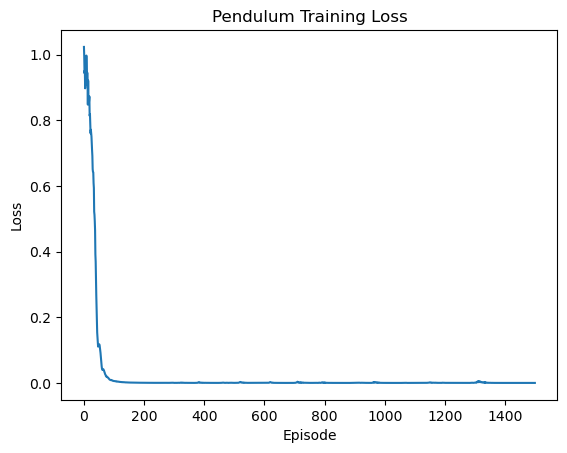

In [163]:
plt.plot(train_losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Pendulum Training Loss")
plt.savefig("figures/pendulum_training_loss_mse.pdf")

## Evaluation

In [164]:
model.eval()

n_min = torch.argmin(eval_losses).item()

n_eval = 1
eval_losses_2 = torch.zeros(99)

#states_i, actions_i = states_eval_batch[n_min,:,:].unsqueeze(0), actions_eval_batch[n_min,:,:].unsqueeze(0)

for n in range(n_eval):

    states_i, actions_i = get_batch(1, n_test_traj, test_traj_states, test_traj_actions)

    state = states_i[0,0,:]
    action = actions_i[0,0,:]

    # we keep all the histories on the device
    # note that the latest action will be "padding"
    states = state.reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = action.reshape(1, act_dim).to(device=device, dtype=torch.float32)
    sim_states = []

    episode_return, episode_length = 0, 0
    for t in range(99):

        # add padding
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)

        pred_state = model.get_state(
            states.to(dtype=torch.float32) ,
            actions.to(dtype=torch.float32),
            (torch.arange(0,t+1,1).unsqueeze(0)).to(device)
        )

        actions[-1] = actions_i[0,t+1].reshape(1, act_dim)

        cur_state = (pred_state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        
#         print(states.size())
#         print(states_i[0,0:t+2,:].size())
        
        loss = nn.MSELoss()
        l = loss(states,(states_i[0,0:t+2,:]).to(device))
        eval_losses_2[t] = l.detach().cpu().item()

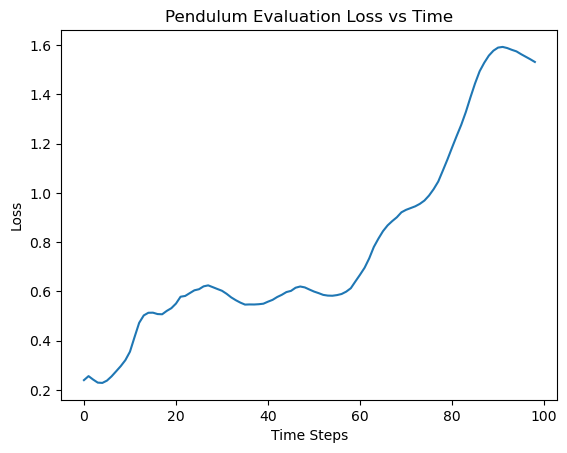

In [165]:
plt.plot(eval_losses_2)
plt.xlabel("Time Steps")
plt.ylabel("Loss")
plt.title("Pendulum Evaluation Loss vs Time")
plt.savefig("figures/pendulum_evaluation_loss_time_mse_2.pdf")

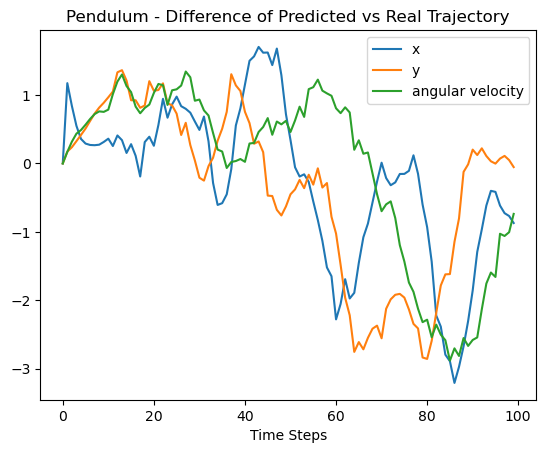

In [166]:
diff = states_i - states.to('cpu')
diff = diff.detach().numpy()
plt.plot(diff[0,:,0], label = "x")
plt.plot(diff[0,:,1], label = "y")
plt.plot(diff[0,:,2], label = "angular velocity")
plt.legend()
plt.xlabel("Time Steps")
#plt.ylim([-6,6])
#plt.ylabel("Loss")
plt.title("Pendulum - Difference of Predicted vs Real Trajectory")
plt.savefig("figures/pendulum_test_diff_mse_2.pdf")

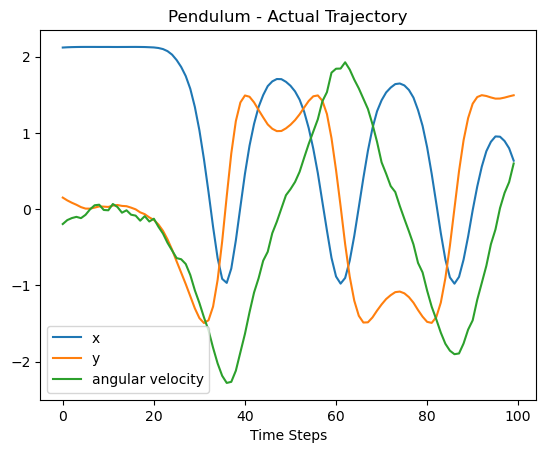

In [167]:
plt.plot(states_i[0,:,0], label = "x")
plt.plot(states_i[0,:,1], label = "y")
plt.plot(states_i[0,:,2], label = "angular velocity")
plt.legend()

plt.xlabel("Time Steps")

#plt.ylabel("Loss")
#plt.ylim([-6,6])

plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")

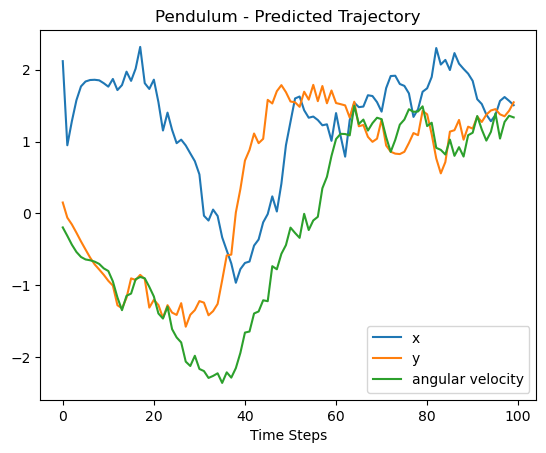

In [168]:
states = states.detach().cpu()
plt.plot(states[0:,0], label = "x")
plt.plot(states[:,1], label = "y")
plt.plot(states[:,2], label = "angular velocity")
plt.legend()
plt.xlabel("Time Steps")
#plt.ylabel("Loss")
#plt.ylim([-6,6])
plt.title("Pendulum - Predicted Trajectory")
plt.savefig("figures/pendulum_pred_real_mse_2.pdf")


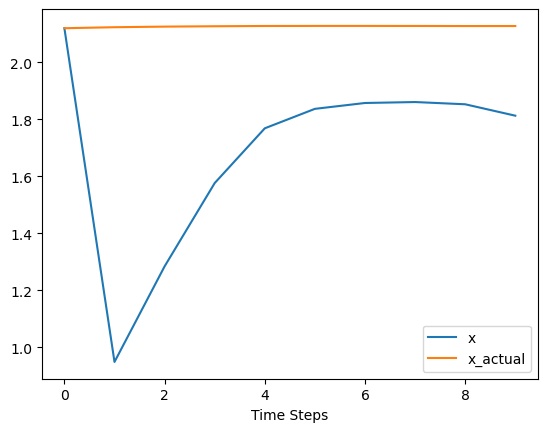

In [169]:
#plt.plot(states_i[0,0:loss_horizon,0], label = "x_actual")
#plt.plot(states[0,0:loss_horizon,0], label = "x")

plt.plot(states[0:loss_horizon,0], label = "x")

plt.plot(states_i[0,0:loss_horizon,0], label = "x_actual")
plt.legend()

plt.xlabel("Time Steps")

#plt.ylabel("Loss")
#plt.ylim([-6,6])

#plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")

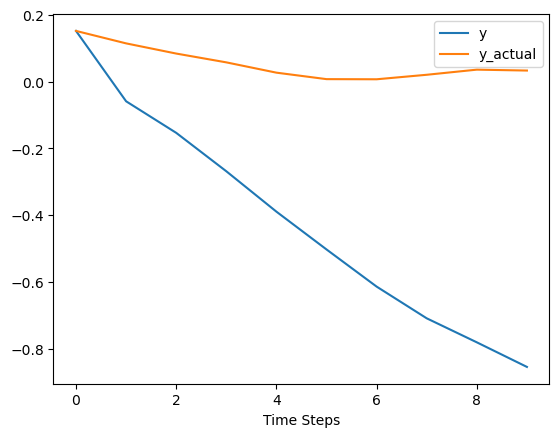

In [170]:
plt.plot(states[0:loss_horizon,1], label = "y")

plt.plot(states_i[0,0:loss_horizon,1], label = "y_actual")
plt.legend()

plt.xlabel("Time Steps")

#plt.ylabel("Loss")
#plt.ylim([-6,6])

#plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")

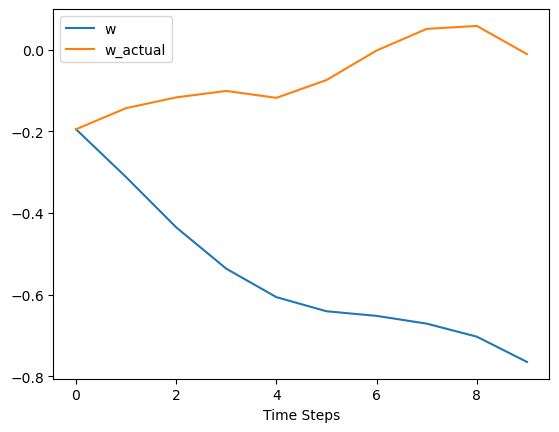

In [171]:
plt.plot(states[0:loss_horizon,2], label = "w")

plt.plot(states_i[0,0:loss_horizon,2], label = "w_actual")

plt.legend()

plt.xlabel("Time Steps")

#plt.ylabel("Loss")
#plt.ylim([-6,6])

#plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")